## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "../src/data/IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)

### Load the data

In [3]:
path_to_data = '../src/data' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [11]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


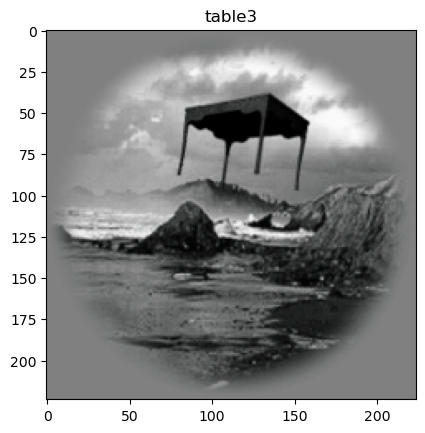

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

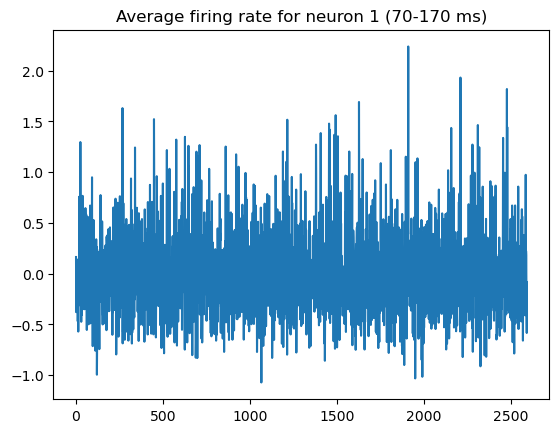

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

linreg = LinearRegression()
ridge = Ridge(alpha=1.0)
ridge_highreg = Ridge(alpha=100.0)

# Flatten the images into a 2D array (n_stimulus, n_channels * img_size * img_size)
stim_train = stimulus_train.reshape(n_stimulus, -1)
scaler = StandardScaler()
stim_train = scaler.fit_transform(stim_train)

linreg.fit(stim_train, spikes_train)
ridge.fit(stim_train, spikes_train)
ridge_highreg.fit(stim_train, spikes_train)

# Evaluate the models on the training data (R^2 score), if too high can indicate overfitting
linreg_score_train = linreg.score(stim_train, spikes_train)
ridge_score_train = ridge.score(stim_train, spikes_train)
ridge_highreg_score_train = ridge_highreg.score(stim_train, spikes_train)

print('Linear regression score on training data: ', linreg_score_train)
print('Ridge regression score on training data: ', ridge_score_train)
print('Ridge regression score with high regularization on training data: ', ridge_highreg_score_train)

stim_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
stim_val = scaler.transform(stim_val)

# Evaluate the models on the validation data (R^2 score)
linreg_score_val = linreg.score(stim_val, spikes_val)
ridge_score_val = ridge.score(stim_val, spikes_val)
ridge_highreg_score_val = ridge_highreg.score(stim_val, spikes_val)

print('Linear regression score on validation data: ', linreg_score_val)
print('Ridge regression score on validation data: ', ridge_score_val)
print('Ridge regression score with high regularization on validation data: ', ridge_highreg_score_val)

c:\Users\Admin\Anaconda3\envs\nx414\Lib\site-packages\sklearn\linear_model\_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=9.84442e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Linear regression score on training data:  0.3840097188949585
Ridge regression score on training data:  0.9999996423721313
Ridge regression score with high regularization on training data:  0.9983475208282471
Linear regression score on validation data:  -0.041136424988508224
Ridge regression score on validation data:  -0.9299604296684265
Ridge regression score with high regularization on validation data:  -0.7975672483444214


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

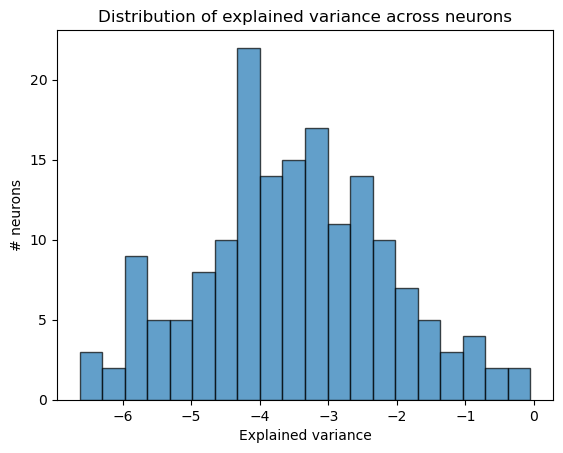

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

def evaluate_model(model, stimulus, spikes):
    pred = model.predict(stimulus.reshape(stimulus.shape[0], -1))

    correlations = []
    explained_variances = []

    for i in range(spikes.shape[1]):
        # Correlation
        corr, _ = pearsonr(pred[:, i], spikes[:, i])
        correlations.append(corr)
        
        # Explained variance
        ev = explained_variance_score(pred[:, i], spikes[:, i])
        explained_variances.append(ev)

    # Plot distribution of explained variance
    plt.hist(explained_variances, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Explained variance')
    plt.ylabel('# neurons')
    plt.title('Distribution of explained variance across neurons')
    plt.show()

evaluate_model(linreg, stimulus_val, spikes_val)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)
stim_train_pca = pca.fit_transform(stim_train)
stim_val_pca = pca.transform(stim_val)

linreg = LinearRegression()
ridge = Ridge(alpha=1.0)
ridge_highreg = Ridge(alpha=100.0)

linreg.fit(stim_train_pca, spikes_train)
ridge.fit(stim_train_pca, spikes_train)
ridge_highreg.fit(stim_train_pca, spikes_train)

linreg_score_train = linreg.score(stim_train_pca, spikes_train)
ridge_score_train = ridge.score(stim_train_pca, spikes_train)
ridge_highreg_score_train = ridge_highreg.score(stim_train_pca, spikes_train)

print('Linear regression score on training data: ', linreg_score_train)
print('Ridge regression score on training data: ', ridge_score_train)
print('Ridge (high reg.) regression score on training data: ', ridge_highreg_score_train)

linreg_score_val = linreg.score(stim_val_pca, spikes_val)
ridge_score_val = ridge.score(stim_val_pca, spikes_val)
ridge_highreg_score_val = ridge_highreg.score(stim_val_pca, spikes_val)

print('Linear regression score on validation data: ', linreg_score_val)
print('Ridge regression score on validation data: ', ridge_score_val)
print('Ridge (high reg.) regression score on validation data: ', ridge_highreg_score_val)

Linear regression score on training data:  0.46676963567733765
Ridge regression score on training data:  0.46676963567733765
Ridge (high reg.) regression score on training data:  0.46676504611968994
Linear regression score on validation data:  -0.08162758499383926
Ridge regression score on validation data:  -0.08161519467830658
Ridge (high reg.) regression score on validation data:  -0.08039043843746185


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold

alphas = np.logspace(0, 10, 20)
ridge = Ridge()

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
splits = list(cv.split(stim_train, objects_train, groups=objects_train))
grid_search = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=splits, n_jobs=-1)
grid_search.fit(stim_train, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(stim_train, spikes_train)
ridge_score_train = best_ridge.score(stim_train, spikes_train)
ridge_score_val = best_ridge.score(stim_val, spikes_val)

print("Best Ridge Regression score on training set:", ridge_score_train)
print("Best Ridge Regression score on validation set:", ridge_score_val)

Best alpha value: 615848.2110660254
Best Ridge Regression score on training set: 0.16825635731220245
Best Ridge Regression score on validation set: 0.08738023042678833


In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold

alphas = np.logspace(0, 10, 20)
ridge = Ridge()

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
splits = list(cv.split(stim_train_pca, objects_train, groups=objects_train))
grid_search = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=splits, n_jobs=-1)
grid_search.fit(stim_train_pca, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(stim_train_pca, spikes_train)
ridge_score_train = best_ridge.score(stim_train_pca, spikes_train)
ridge_score_val = best_ridge.score(stim_val_pca, spikes_val)

print("Best Ridge Regression score on training set:", ridge_score_train)
print("Best Ridge Regression score on validation set:", ridge_score_val)

Best alpha value: 615848.2110660254
Best Ridge Regression score on training set: 0.15876375138759613
Best Ridge Regression score on validation set: 0.08638522773981094


### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
import torch
from torchvision.models import resnet50
from sklearn.decomposition import PCA

## 1: Give stimuli as input & get activations from the model. Save only 1000 first PCs for each layer

pretrained_resnet = resnet50(pretrained=True)
pretrained_resnet.eval()

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

PCs = {'pretrained': dict(), 'untrained': dict()}

def get_PCs_hook(module, input, output, layer_name, model):
    print('Layer:', layer_name)
    activations = output.detach().cpu().numpy().reshape(output.shape[0], -1)
    print('Activations shape:', activations.shape)
    pca = PCA(n_components=1000)
    pca_features = pca.fit_transform(activations)
    print('Principal components shape:', pca_features.shape)
    PCs[model][layer_name] = pca_features

for name, layer in pretrained_resnet.named_children():
    if name in layers:
        layer.register_forward_hook(lambda m, i, o, name=name: get_PCs_hook(m, i, o, name, 'pretrained'))

imgs = stimulus_train
imgs = torch.from_numpy(imgs)
with torch.no_grad():
    pretrained_resnet(imgs)

c:\Users\Admin\Anaconda3\envs\nx414\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Anaconda3\envs\nx414\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer: conv1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer2
Activations shape: (2592, 401408)
Principal components shape: (2592, 1000)
Layer: layer3
Activations shape: (2592, 200704)
Principal components shape: (2592, 1000)
Layer: layer4
Activations shape: (2592, 100352)
Principal components shape: (2592, 1000)
Layer: avgpool
Activations shape: (2592, 2048)
Principal components shape: (2592, 1000)


In [ ]:
## 2: use PCs to predict neural activity using linear regression

def get_activity_by_layer(layer, model):
    pcs = PCs[model][layer]
    linreg = LinearRegression()
    linreg.fit(pcs, spikes_train)
    pred_activity = linreg.predict(pcs)
    return pred_activity

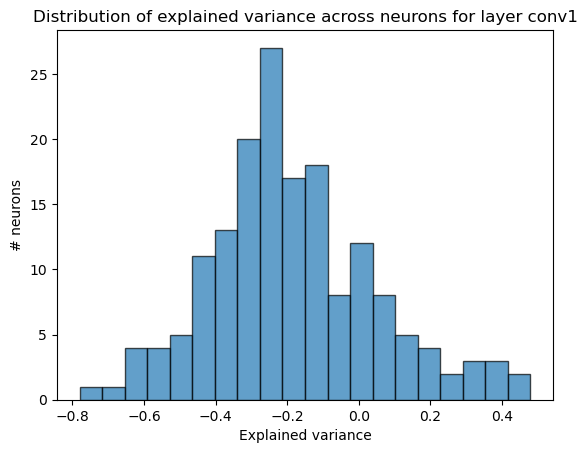

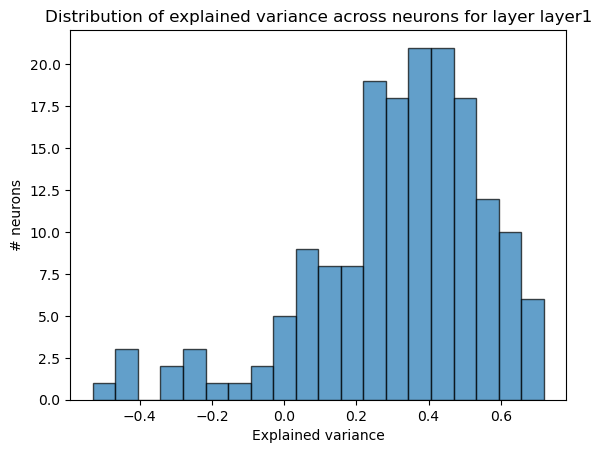

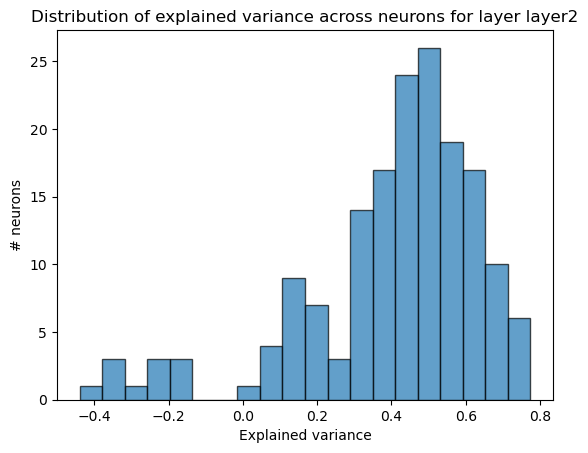

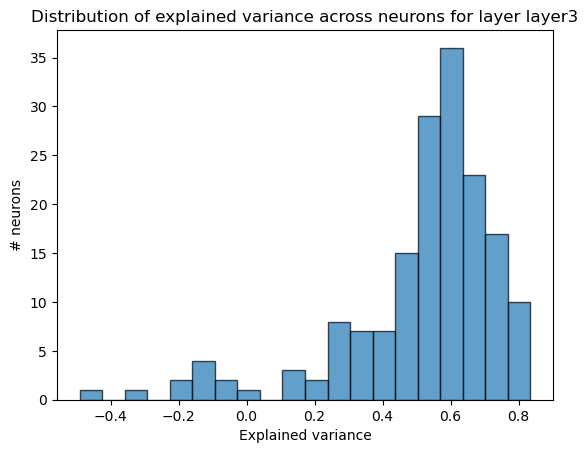

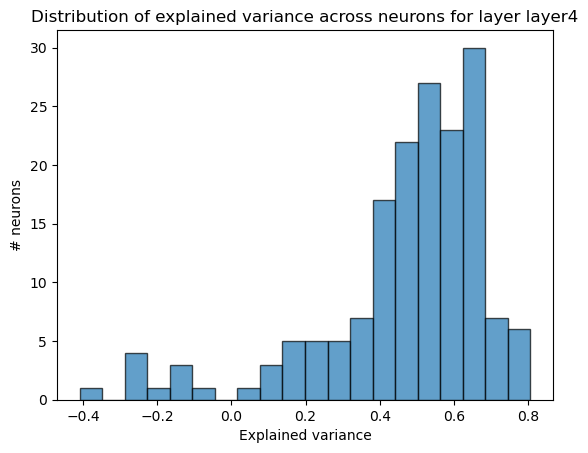

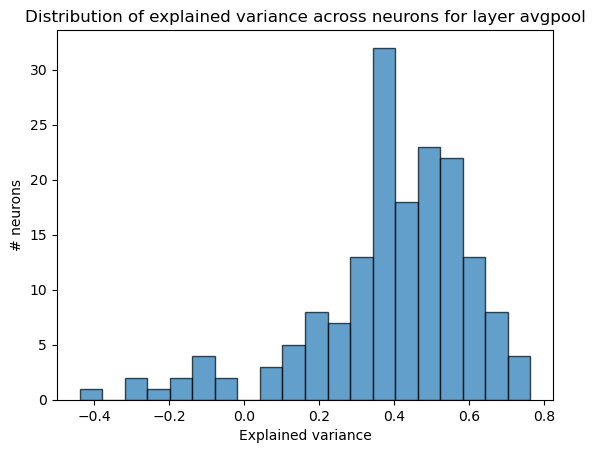

In [ ]:
## 3: Compute goodness of fit and explained variance for each layer, plot explained variance per layer
for layer in layers:
    pred_activity = get_activity_by_layer(layer, 'pretrained')
    correlations = []
    explained_variances = []

    for i in range(spikes_train.shape[1]):
        # Correlation
        corr, _ = pearsonr(pred_activity[:, i], spikes_train[:, i])
        correlations.append(corr)
        
        # Explained variance
        ev = explained_variance_score(pred_activity[:, i], spikes_train[:, i])
        explained_variances.append(ev)

    # Plot distribution of explained variance
    plt.hist(explained_variances, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Explained variance')
    plt.ylabel('# neurons')
    plt.title('Distribution of explained variance across neurons for layer {}'.format(layer))
    plt.show()

c:\Users\Admin\Anaconda3\envs\nx414\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Anaconda3\envs\nx414\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer: conv1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer2
Activations shape: (2592, 401408)
Principal components shape: (2592, 1000)
Layer: layer3
Activations shape: (2592, 200704)
Principal components shape: (2592, 1000)
Layer: layer4
Activations shape: (2592, 100352)
Principal components shape: (2592, 1000)
Layer: avgpool
Activations shape: (2592, 2048)
Principal components shape: (2592, 1000)


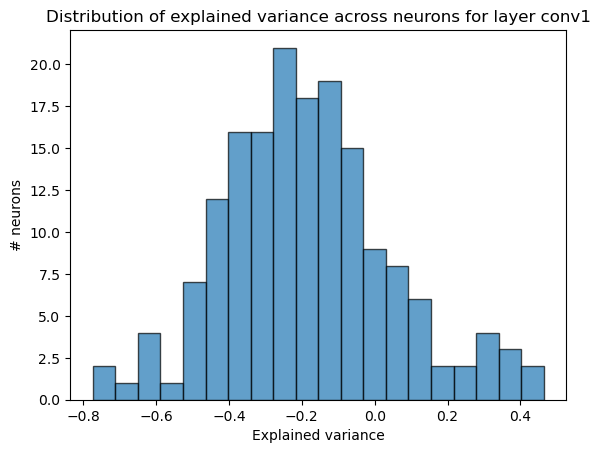

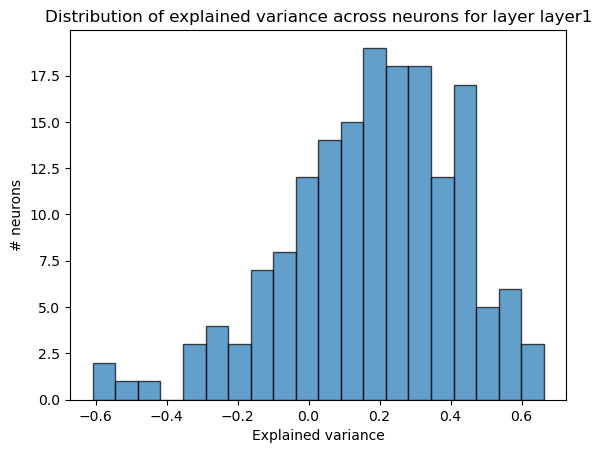

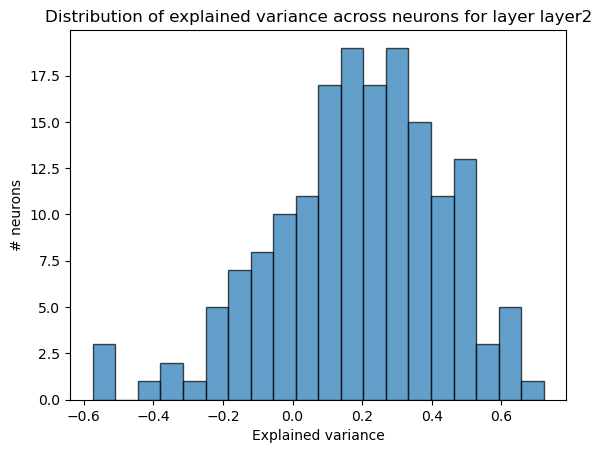

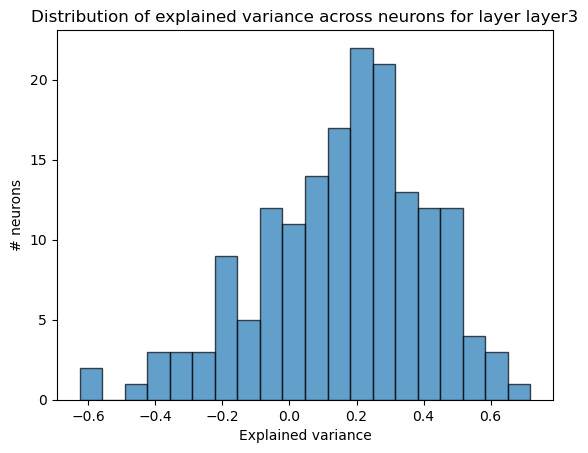

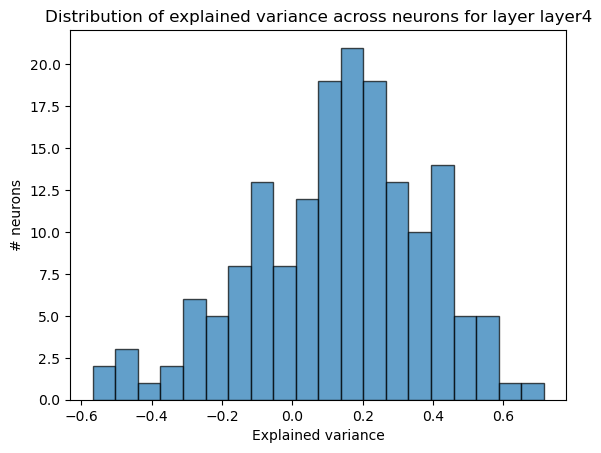

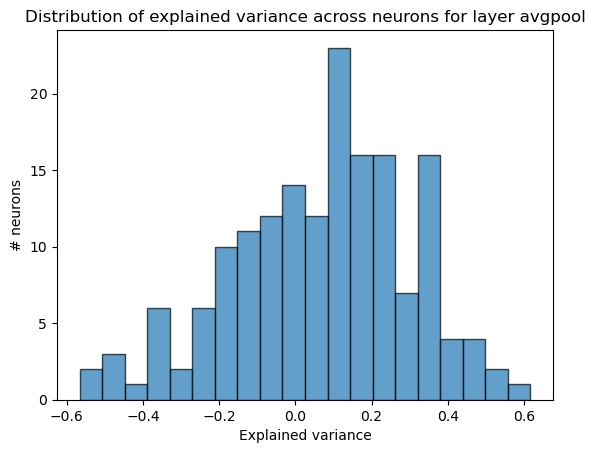

In [ ]:
## 4: Do the same for an untrained network

untrained_resnet = resnet50(pretrained=False)
untrained_resnet.eval()

for name, layer in untrained_resnet.named_children():
    if name in layers:
        layer.register_forward_hook(lambda m, i, o, name=name: get_PCs_hook(m, i, o, name, 'untrained'))

imgs = stimulus_train
imgs = torch.from_numpy(imgs)
with torch.no_grad():
    untrained_resnet(imgs)

for layer in layers:
    pred_activity = get_activity_by_layer(layer, 'untrained')
    correlations = []
    explained_variances = []

    for i in range(spikes_train.shape[1]):
        # Correlation
        corr, _ = pearsonr(pred_activity[:, i], spikes_train[:, i])
        correlations.append(corr)
        
        # Explained variance
        ev = explained_variance_score(pred_activity[:, i], spikes_train[:, i])
        explained_variances.append(ev)

    # Plot distribution of explained variance
    plt.hist(explained_variances, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Explained variance')
    plt.ylabel('# neurons')
    plt.title('Distribution of explained variance across neurons for layer {}'.format(layer))
    plt.show()